In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Final Project

# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [3]:
# Imports loan data

df = pd.DataFrame()
files = os.listdir('./Source Data/Loan Data')
csvs = []
for file in files:
    if re.match('.*csv$',file):
        csvs += [file]
cols = df.dtypes
for csv in csvs:
    path = './Source Data/Loan Data/' + csv
    tdf = pd.read_csv(path,header=1,low_memory=False,)
    df=df.append(tdf)
df.reset_index(inplace=True) # This will help with joining back data if necessary.

In [4]:
pd.set_option('display.max_rows', 151)
print(df.dtypes)
pd.set_option('display.max_rows', 20)

index                                           int64
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                  

In [5]:
# Checks for duplicates within our combined data
df['count']=1 # Generate field to measure the number of occurances

counts = df.groupby('id')['count'].count()
print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.


Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [6]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
has_data

{'index': 1873317,
 'id': 1873317,
 'member_id': 0,
 'loan_amnt': 1873290,
 'funded_amnt': 1873290,
 'funded_amnt_inv': 1873290,
 'term': 1873290,
 'int_rate': 1873290,
 'installment': 1873290,
 'grade': 1873290,
 'sub_grade': 1873290,
 'emp_title': 1751367,
 'emp_length': 1758942,
 'home_ownership': 1873290,
 'annual_inc': 1873286,
 'verification_status': 1873290,
 'issue_d': 1873290,
 'loan_status': 1873290,
 'pymnt_plan': 1873290,
 'url': 1873290,
 'desc': 126067,
 'purpose': 1873290,
 'title': 1849965,
 'zip_code': 1873289,
 'addr_state': 1873290,
 'dti': 1872449,
 'delinq_2yrs': 1873261,
 'earliest_cr_line': 1873261,
 'fico_range_low': 1873290,
 'fico_range_high': 1873290,
 'inq_last_6mths': 1873260,
 'mths_since_last_delinq': 930745,
 'mths_since_last_record': 311441,
 'open_acc': 1873261,
 'pub_rec': 1873261,
 'revol_bal': 1873290,
 'revol_util': 1871931,
 'total_acc': 1873261,
 'initial_list_status': 1873290,
 'out_prncp': 1873290,
 'out_prncp_inv': 1873290,
 'total_pymnt': 187

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

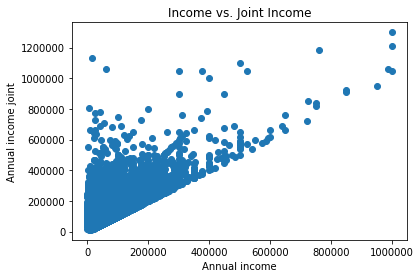

In [7]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;

Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [9]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data
# Convert the loan issue date to a datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
#data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
#features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
#reduced_df=reduced_df[features]
#
## Combines fields when necessary
#reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2
#reduced_df.drop(columns=[
#    'fico_range_low',
#    'fico_range_high',
#],inplace=True)

Timestamp('2007-06-01 00:00:00')

In [11]:
len(df[mature_filter])

1020552

In [10]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', nan, 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [27]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
n_options

{'acc_open_past_24mths': 58,
 'all_util': 185,
 'annual_inc': 80238,
 'annual_inc_joint': 11233,
 'application_type': 2,
 'bc_open_to_buy': 84096,
 'chargeoff_within_12_mths': 12,
 'collection_recovery_fee': 110546,
 'collections_12_mths_ex_med': 17,
 'delinq_2yrs': 35,
 'dti': 9010,
 'dti_joint': 3921,
 'earliest_cr_line': 742,
 'emp_length': 12,
 'home_ownership': 6,
 'inq_fi': 32,
 'inq_last_12m': 47,
 'inq_last_6mths': 29,
 'installment': 88440,
 'int_rate': 638,
 'loan_amnt': 1572,
 'mo_sin_old_il_acct': 553,
 'mo_sin_old_rev_tl_op': 774,
 'mo_sin_rcnt_rev_tl_op': 314,
 'mo_sin_rcnt_tl': 216,
 'mort_acc': 47,
 'mths_since_last_delinq': 172,
 'mths_since_last_major_derog': 180,
 'mths_since_last_record': 127,
 'mths_since_rcnt_il': 381,
 'mths_since_recent_bc': 520,
 'mths_since_recent_bc_dlq': 173,
 'mths_since_recent_inq': 27,
 'mths_since_recent_revol_delinq': 174,
 'num_accts_ever_120_pd': 44,
 'num_bc_sats': 58,
 'num_bc_tl': 74,
 'num_il_tl': 121,
 'num_op_rev_tl': 80,
 'num_

Based on these results, we will have to encode several data as dummy variables:
- home_ownership
- term
- application_type
- verification_status